# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

# 1. Подготовка данных

### 1.0 Загрузка и предварительный анализ данных

In [2]:
gold_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold = pd.read_csv('/datasets/gold_recovery_full.csv')
print('Размеры полной, тренировочной и тестовой выборок:')
print(gold.shape,gold_train.shape,gold_test.shape)
display(pd.Series(gold_train.columns[gold_train.columns.str.contains('au')]))
print(gold['date'].head())

Размеры полной, тренировочной и тестовой выборок:
(22716, 87) (16860, 87) (5856, 53)


0                           final.output.concentrate_au
1                                  final.output.tail_au
2                 primary_cleaner.output.concentrate_au
3                        primary_cleaner.output.tail_au
4         rougher.calculation.sulfate_to_au_concentrate
5     rougher.calculation.floatbank10_sulfate_to_au_...
6     rougher.calculation.floatbank11_sulfate_to_au_...
7                       rougher.calculation.au_pb_ratio
8                                 rougher.input.feed_au
9                         rougher.output.concentrate_au
10                               rougher.output.tail_au
11                     secondary_cleaner.output.tail_au
dtype: object

0    2016-01-15 00:00:00
1    2016-01-15 01:00:00
2    2016-01-15 02:00:00
3    2016-01-15 03:00:00
4    2016-01-15 04:00:00
Name: date, dtype: object


Определим различающиеся столбцы в тренировочной и тестовой выборках и выведем их на экран

In [3]:
result=list(set(gold_train.columns) ^ set(gold_test.columns))
print(pd.Series(result))

0                               rougher.output.recovery
1                                 final.output.tail_sol
2                         rougher.output.concentrate_pb
3                                rougher.output.tail_ag
4                        primary_cleaner.output.tail_au
5                         rougher.output.concentrate_au
6                      secondary_cleaner.output.tail_pb
7                 primary_cleaner.output.concentrate_ag
8                 primary_cleaner.output.concentrate_au
9                                 final.output.recovery
10                               rougher.output.tail_au
11                          final.output.concentrate_au
12                                 final.output.tail_ag
13                    secondary_cleaner.output.tail_sol
14    rougher.calculation.floatbank10_sulfate_to_au_...
15                        rougher.output.concentrate_ag
16               primary_cleaner.output.concentrate_sol
17                       primary_cleaner.output.

__Вывод__ В тестовых данных отсутствует значение целевого признака rougher.output.recovery, которое нам и надо найти.

Все признаки, недоступные в тестовой выборке, относятся к выходным данным каждого этапа процесса.

### 1.1 Предобработка данных
__Удаление пропусков__
Найдем пропущенные значения в целевом прзнаке тренировочных данных для последующего обучения модели.

In [4]:
print('Процент пропущенных значений в массиве:')
print('всех данных: {:.2%}'.format(gold['rougher.output.recovery'].isna().sum()/gold.shape[0]))
print('тренировочных данных: {:.2%}'.format(gold_train['rougher.output.recovery'].isna().sum()/gold_train.shape[0]))

Процент пропущенных значений в массиве:
всех данных: 13.73%
тренировочных данных: 15.26%


__Определим пропущенные и нулевые значения в других столбцах для дальнейших расчетов__


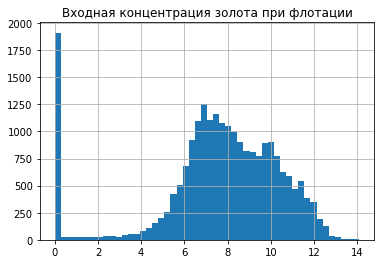

Количество пропущенных значений в целевом столбце для образцов с нулевой начальноц концентрацией золота
для финальной очистки 1528
для флотации 1528


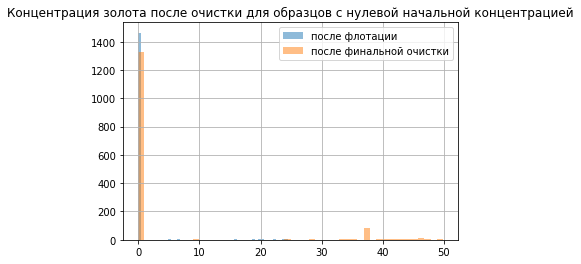

In [5]:
calculated_columns = gold.columns[gold.columns.str.contains('au')]
gold['rougher.input.feed_au'].hist(bins=50)
plt.title('Входная концентрация золота при флотации')
plt.show()
gold[gold['rougher.input.feed_au'] == 0]['rougher.output.concentrate_au'].hist(bins=50,alpha=0.5,label='после флотации')
gold[gold['rougher.input.feed_au'] == 0]['final.output.concentrate_au'].hist(bins=50,alpha=0.5, label='после финальной очистки')
print('Количество пропущенных значений в целевом столбце для образцов с нулевой начальноц концентрацией золота\nдля финальной очистки',gold[gold['rougher.input.feed_au'] == 0]['final.output.recovery'].isna().sum())
print('для флотации',gold[gold['rougher.input.feed_au'] == 0]['rougher.output.recovery'].isna().sum())
plt.title('Концентрация золота после очистки для образцов с нулевой начальной концентрацией')
plt.legend()
plt.show()

Из графиков выше можно сделать вывод о том, что при нулевых начальных значений концентрации золота в образце, дальнейшие концентрации также равны нулю ,а целевые признаки отсутствуют. Поэтому избавимся от нулевых значений.

In [6]:
# удаляем нули в столбце доля золота в сырье/концентрате до флотации/очистки;
gold=gold[gold['rougher.input.feed_au'].values!=0]

print('\nНулевые значения в столбцах\n',gold[gold[calculated_columns]==0][calculated_columns].count())


Нулевые значения в столбцах
 final.output.concentrate_au                            291
final.output.tail_au                                   646
primary_cleaner.output.concentrate_au                  235
primary_cleaner.output.tail_au                         583
rougher.calculation.sulfate_to_au_concentrate            0
rougher.calculation.floatbank10_sulfate_to_au_feed       0
rougher.calculation.floatbank11_sulfate_to_au_feed       0
rougher.calculation.au_pb_ratio                          0
rougher.input.feed_au                                    0
rougher.output.concentrate_au                          490
rougher.output.tail_au                                   0
secondary_cleaner.output.tail_au                      1379
dtype: int64


Теперь больше всего пропущенных значений из целевых признаков в столбце rougher.output.tail_au.
Проведем анализ.

__Вывод__

NaN значение в концентрациях золота в отвальных хвостах после флотации, также чаще всего получается, когда на выходе после флотации у нас нулевая концентрация.
В итоге, пропуски в целевых столбцах с содержанием золота, могут испортить обучение модели, 


In [7]:
target_columns = ['rougher.output.recovery','final.output.recovery']
print('Пропущенные данные в столбцах, кол-во:\n',gold[target_columns].isna().sum())
gold.dropna(subset=target_columns,inplace = True)

Пропущенные данные в столбцах, кол-во:
 rougher.output.recovery    1591
final.output.recovery       435
dtype: int64


__Заполнение пропусков в не целевых столбцах__

Предположим, что близкие по времени образцы имеют похожие параметры.
В таком случае заполним пропуски в нецелевых столбцах ближайшими значениями.

In [8]:
gold=gold.fillna(method='ffill')

### 1.2. Проверка правильности расчета целевого признака rougher.output.recovery для тренировочных данных

Для этого используются данные:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Recovery = C*(F-T)/(F*(C-T))*100

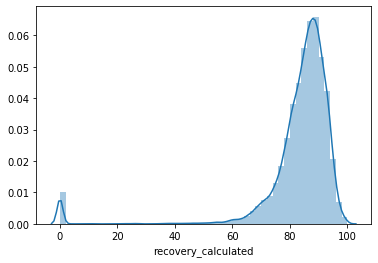

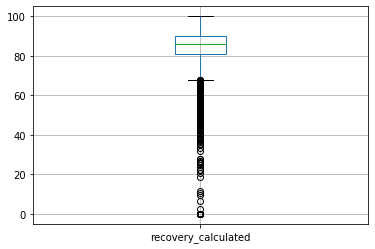

In [9]:
def output(data):
    C = data['rougher.output.concentrate_au']
    F = data['rougher.input.feed_au']
    T = data['rougher.output.tail_au']
    rec = C*(F-T)/(F*(C-T))*100
    return rec
gold['recovery_calculated'] = gold.apply(output,axis=1)
gold.dropna(subset=['recovery_calculated'],inplace=True)
sns.distplot(gold['recovery_calculated'])
plt.show()
gold.boxplot(column= ['recovery_calculated'])
plt.show()
gold=gold[gold['recovery_calculated'].values >=0]
gold=gold[gold['recovery_calculated'].values <100]
# print(gold_train['rougher.output.concentrate_au'].isna().sum())
# print(gold_train['rougher.input.feed_au'].isna().sum())
# print(gold_train['rougher.output.tail_au'].isna().sum())
# print(gold_train['recovery_calculated'].isna().sum())

Избавимся от выбросов из за значений в расчетах, близких к нулю. Оставим значения от 0 до 100.

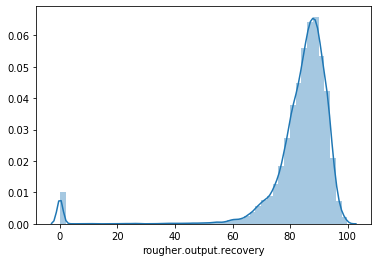

In [10]:
sns.distplot(gold['rougher.output.recovery'])

__Расчет MAE для рассчитанного вручную целевого признака__

In [11]:
recovery_mae = mean_absolute_error(gold['recovery_calculated'],gold['rougher.output.recovery'])
print(recovery_mae)

9.833260296606938e-15


__Вывод__
Что ж, рассчитаный целевой признак почти не отличается от указанного в исходных данных, правда, до этого пришлось поработать с данными: мы удалили образцы с нулевым содержанием золота, а также наблюдения без целевого признака.

Медиана целевого признака находится на 85%. половина значений целевого признака находится от 80 до 90%, что показывает эффективность многоэтапной очистки золота.

Целевой признак распределен нормально с небольшой дисперсией, что говорит о том, что очистка является стабильной и приводит к ожидаемому результату.

Далее построим модель для предсказания качества очистки образца, а также определим, от каких факторов больше всего зависит качество очистки.

### 1.3. Анализ признаков, не доступных в тестовой выборке

In [12]:
result=list(set(gold.columns) ^ set(gold_test.columns))
result =pd.Series(result)
#определим только те столбцы, в которых присутствует золото
result_au = result[result.str.contains('au')]
print(result_au)

5                        primary_cleaner.output.tail_au
6                         rougher.output.concentrate_au
9                 primary_cleaner.output.concentrate_au
11                               rougher.output.tail_au
12                          final.output.concentrate_au
17    rougher.calculation.floatbank10_sulfate_to_au_...
22                     secondary_cleaner.output.tail_au
24                                 final.output.tail_au
26    rougher.calculation.floatbank11_sulfate_to_au_...
30        rougher.calculation.sulfate_to_au_concentrate
34                      rougher.calculation.au_pb_ratio
dtype: object


__Вывод__
В тестовой выборке отсутствует множество столбцов, связанных с концентрацией разных веществ в образце после этапов очистки.
Естественно, в тестовой выборке отсутсвует целевой признак.

Также в тестовой выборке отсутствует значения:
- концентрации золота в хвостах на каждом этапе.
- концентрации золота в образце после финальной очистки и флотации.
- отношение золота к свинцу в финальном образце.
- отношения золота к сульфиду натрия при флотации.
- и т.д.

Что самое важное - в тестовой выборке отсутствуют 2 из 3 значений, используемых при расчете целевого признака:
- ['rougher.output.tail_au']
- ['rougher.output.tail_au']

При обучении модели будет проверяться, насколько точно можно предсказать целевой признак по остальным значениям этапов очистки.


# 2. Анализ данных

### 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

0            rougher.output.concentrate_au
1    primary_cleaner.output.concentrate_au
2              final.output.concentrate_au
dtype: object


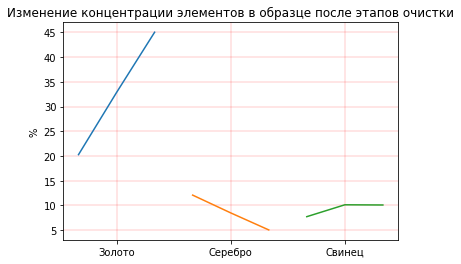

In [13]:
gold_columns_au = pd.Series(gold.columns[gold.columns.str.contains('concentrate_au')][::-1])
gold_columns_pb=pd.Series(gold.columns[gold.columns.str.contains('concentrate_pb')][::-1])
gold_columns_ag=pd.Series(gold.columns[gold.columns.str.contains('concentrate_ag')][::-1])
print(gold_columns_au)
gold_changes_au = gold.dropna(subset=gold_columns_au)[gold_columns_au].median()
gold_changes_ag = gold.dropna(subset=gold_columns_ag)[gold_columns_ag].median()
gold_changes_pb = gold.dropna(subset=gold_columns_pb)[gold_columns_pb].median()
fig, ax = plt.subplots()
plt.title("Изменение концентрации элементов в образце после этапов очистки")
plt.xticks([1, 4, 7], ['Золото', 'Серебро', 'Свинец'])
plt.ylabel("%")
plt.grid(color='r', linestyle='-', linewidth=0.2)
ax.plot(gold_changes_au)
ax.plot(gold_changes_ag)
ax.plot(gold_changes_pb)

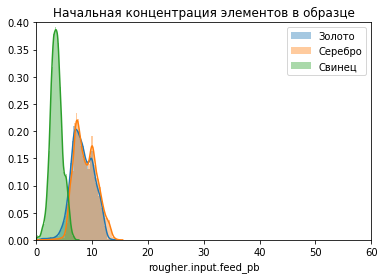

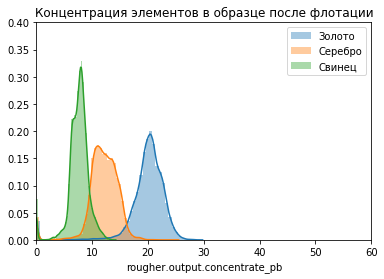

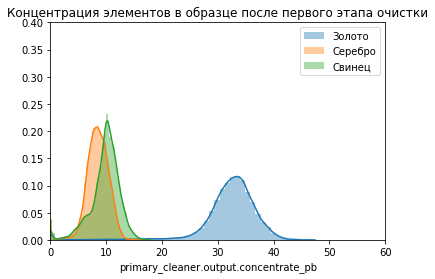

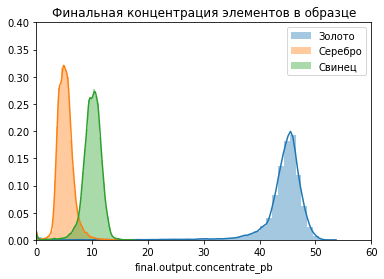

In [14]:
# gold.dropna(subset=['rougher.input.feed_au',
#                     'rougher.input.feed_ag',
#                     'rougher.input.feed_pb'],inplace=True)
sns.distplot(gold['rougher.input.feed_au'],label='Золото')
sns.distplot(gold['rougher.input.feed_ag'],label='Серебро')
sns.distplot(gold['rougher.input.feed_pb'],label='Свинец')
plt.legend()
plt.title('Начальная концентрация элементов в образце')
plt.xlim(0,60)
plt.ylim(0,0.4)
plt.show()


# gold.dropna(subset=['rougher.output.concentrate_au',
#                     'rougher.output.concentrate_ag',
#                     'rougher.output.concentrate_pb'],inplace=True)
sns.distplot(gold['rougher.output.concentrate_au'],label='Золото')
sns.distplot(gold['rougher.output.concentrate_ag'],label='Серебро')
sns.distplot(gold['rougher.output.concentrate_pb'],label='Свинец')
plt.legend()
plt.title('Концентрация элементов в образце после флотации')
plt.xlim(0,60)
plt.ylim(0,0.4)
plt.show()

# gold.dropna(subset=['primary_cleaner.output.concentrate_au',
#                     'primary_cleaner.output.concentrate_ag',
#                     'primary_cleaner.output.concentrate_pb'],inplace=True)
sns.distplot(gold['primary_cleaner.output.concentrate_au'],label='Золото')
sns.distplot(gold['primary_cleaner.output.concentrate_ag'],label='Серебро')
sns.distplot(gold['primary_cleaner.output.concentrate_pb'],label='Свинец')
plt.legend()
plt.title('Концентрация элементов в образце после первого этапа очистки')
plt.xlim(0,60)
plt.ylim(0,0.4)
plt.show()

# gold.dropna(subset=['final.output.concentrate_au',
#                     'final.output.concentrate_ag',
#                     'final.output.concentrate_pb'],inplace=True)
sns.distplot(gold['final.output.concentrate_au'],label='Золото')
sns.distplot(gold['final.output.concentrate_ag'],label='Серебро')
sns.distplot(gold['final.output.concentrate_pb'],label='Свинец')
plt.legend()
plt.title('Финальная концентрация элементов в образце')
plt.xlim(0,60)
plt.ylim(0,0.4)
plt.show()


__Вывод__

На графике выше представлены изменения средних концентраций на трёх этапах очистки для золота, серебра и свинца.

Концентрация золота увеличивается, а концентрация серебра уменьшается, соответственно, более, чем в 2 раза.
Концентрация свинца в образце немного увеличивается, но потом остается на прежнем уровне.

На гистограмме плотностей распределения видно, что после очистки уменьшается дисперсия распределния концентрации элементов; золото сдвигается вправо - в сторону большей концентрации, свиней и серебро - влево.

Также представим распределение каждого вещества по этапам

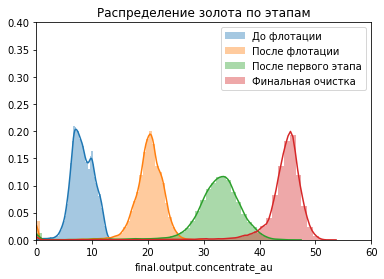

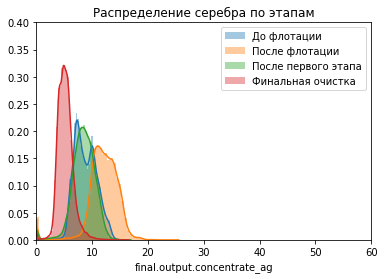

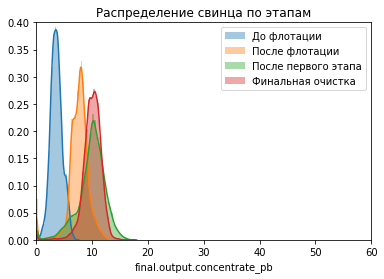

In [15]:
sns.distplot(gold['rougher.input.feed_au'],label='До флотации')
sns.distplot(gold['rougher.output.concentrate_au'],label='После флотации')
sns.distplot(gold['primary_cleaner.output.concentrate_au'],label='После первого этапа')
sns.distplot(gold['final.output.concentrate_au'],label='Финальная очистка')
plt.legend()
plt.xlim(0,60)
plt.ylim(0,0.4)
plt.title('Распределение золота по этапам')
plt.show()

sns.distplot(gold['rougher.input.feed_ag'],label='До флотации')
sns.distplot(gold['rougher.output.concentrate_ag'],label='После флотации')
sns.distplot(gold['primary_cleaner.output.concentrate_ag'],label='После первого этапа')
sns.distplot(gold['final.output.concentrate_ag'],label='Финальная очистка')
plt.legend()
plt.xlim(0,60)
plt.ylim(0,0.4)
plt.title('Распределение серебра по этапам')
plt.show()

sns.distplot(gold['rougher.input.feed_pb'],label='До флотации')
sns.distplot(gold['rougher.output.concentrate_pb'],label='После флотации')
sns.distplot(gold['primary_cleaner.output.concentrate_pb'],label='После первого этапа')
sns.distplot(gold['final.output.concentrate_pb'],label='Финальная очистка')
plt.legend()
plt.xlim(0,60)
plt.ylim(0,0.4)
plt.title('Распределение свинца по этапам')
plt.show()

__Вывод__

Также мы видим, что доля серебра уменьшается обратно пропорционально доле золота.
Однако доля свинца увеличивается, хотя и остается заметно меньше доли золота после финальной очистки.

__Выбросы__
У золота присутствуют аномальные значения в районе 0 на каждом этапе.
Избавимся от них, приняв доверительный интервал - 2.5% снизу, отбросив все значения ниже.

In [16]:
gold=gold[gold['final.output.recovery'] > gold['final.output.recovery'].quantile(0.025)]
gold=gold[gold['rougher.output.concentrate_au'] > gold['rougher.output.concentrate_au'].quantile(0.025)]
gold=gold[gold['primary_cleaner.output.concentrate_au'] > gold['primary_cleaner.output.concentrate_au'].quantile(0.025)]
gold=gold[gold['final.output.concentrate_au'] > gold['final.output.concentrate_au'].quantile(0.025)]

__Использование предобработанных данных в тестовой и тренировочной выборках__

На предыдущих этапах мы подготовили и проверили на адекватность и соответствие условиям задачи все данные. Теперь распределим эти данные по заранее разбитым выборкам.

В тестовой и тренировочной выборках данные согласуются по времени наблюдения.
Используя дату и время как индекс, заменим значения из выборок на значения из предобработанных данных.

In [17]:
gold.set_index('date',inplace=True)
gold_train.set_index('date',inplace=True)
gold_test.set_index('date',inplace=True)

In [18]:
print(len(list(set(gold.index) ^ set(gold_train.index))))

9027


In [19]:
gold_index=pd.Series(gold.index)
gold_train_index=pd.Series(gold_train.index)
gold_test_index=pd.Series(gold_test.index)
gold_short = gold[gold_test.columns]
print(gold_short.shape, gold_test.shape)
gold = gold.drop('recovery_calculated',axis=1)
for i in gold_test_index.values:
    gold_test[gold_test.index == i] = gold_short[gold_short.index == i]
for i in gold_train_index.values:
    gold_train[gold_train.index == i] = gold[gold.index == i]

(17561, 52) (5856, 52)


In [20]:
# поскольку при подготовке данных некоторые строки в исходных данных были удалены,
# остались некоторые пустые строки при переносе данных из исходных данных в выборки/
# надо их удалить
gold_test.dropna(inplace=True)
gold_train.dropna(inplace=True)

### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

__Нулевая гипотеза__ размеры гранул на тестовой и тренировочной выборках равны.

__Альтернативная гипотеза__ размеры гранул на тестовой и тренировочной выборках различаются. 

In [21]:
gold_train_size_columns = pd.Series(gold_train.columns[gold_train.columns.str.contains('feed_size')])
gold_test_size_columns = pd.Series(gold_test.columns[gold_test.columns.str.contains('feed_size')])
gold_test_size = gold_test.dropna(subset=gold_test_size_columns)[gold_test_size_columns]
gold_train_size = gold_train.dropna(subset=gold_train_size_columns)[gold_train_size_columns]

In [22]:
state = np.random.RandomState(12345)

values1=gold_test_size['primary_cleaner.input.feed_size']
values2=gold_train_size['primary_cleaner.input.feed_size']
values3=gold_test_size['rougher.input.feed_size']
values4=gold_train_size['rougher.input.feed_size']
AB_difference = abs(values4.mean() - values3.mean()) ### тоже должен быть модуль
print("Разность средних значений размеров гранул после флотации",AB_difference)
bootstrap_samples = 1000
state = np.random.RandomState(12345)
count = 0
for i in range(bootstrap_samples):
    united_samples1 = pd.concat([values3, values4])
    subsample1 = united_samples1.sample(frac=1, replace=True, random_state=state)
    subsample_3 = subsample1[:len(values3)]
    subsample_4 = subsample1[len(values3):]
    bootstrap_difference = abs(subsample_4.mean()-subsample_3.mean())
    if bootstrap_difference >= AB_difference:
        count += 1

# p-value равно доле превышений значений
pvalue = count / bootstrap_samples
print('p-value =', pvalue)

if pvalue < 0.05:
    print("Отвергаем нулевую гипотезу: скорее всего, разница велика")
else:
    print("Не получилось отвергнуть нулевую гипотезу: скорее всего, разница не значительна")
    

AB_difference = abs(values2.mean() - values1.mean()) ### должен быть модуль
print("Разность средних значений размеров гранул после первого этапа очистки",AB_difference)
bootstrap_samples = 1000
state = np.random.RandomState(12345)
count = 0
for i in range(bootstrap_samples):
    united_samples2 = pd.concat([values1, values2])
    subsample2 = united_samples2.sample(frac=1, replace=True, random_state=state)
    subsample_1 = subsample2[:len(values1)]
    subsample_2 = subsample2[len(values1):]
    bootstrap_difference = abs(subsample_2.mean()-subsample_1.mean())
    if bootstrap_difference >= AB_difference:
        count += 1

# p-value равно доле превышений значений
pvalue = count / bootstrap_samples
print('p-value =', pvalue)

if pvalue < 0.05:
    print("Отвергаем нулевую гипотезу: скорее всего, разница статистически велика")
else:
    print("Не получилось отвергнуть нулевую гипотезу: скорее всего, разница не значительна")

Разность средних значений размеров гранул после флотации 4.336870619159043
p-value = 0.0
Отвергаем нулевую гипотезу: скорее всего, разница велика
Разность средних значений размеров гранул после первого этапа очистки 0.07615148921302861
p-value = 0.0
Отвергаем нулевую гипотезу: скорее всего, разница статистически велика


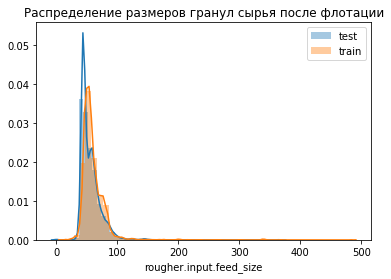

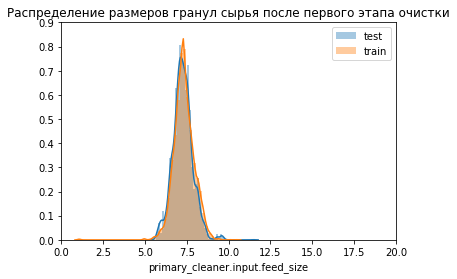

In [23]:
plt.title('Распределение размеров гранул сырья после флотации')
sns.distplot(gold_test_size['rougher.input.feed_size'],label='test')  
sns.distplot(gold_train_size['rougher.input.feed_size'],label='train') 
plt.legend()
plt.show()
plt.title('Распределение размеров гранул сырья после первого этапа очистки')
sns.distplot(gold_test_size['primary_cleaner.input.feed_size'],label='test')  
sns.distplot(gold_train_size['primary_cleaner.input.feed_size'],label='train') 
plt.plot(gold_test_size['primary_cleaner.input.feed_size'].mean())
plt.plot(gold_train_size['primary_cleaner.input.feed_size'].mean())
plt.xlim(0,20)
plt.ylim(0,0.9)
plt.legend()
plt.show()

__Вывод__

Несмотря на то, что статистическая значимость разницы двух выборок значительна, чтобы её пренебречь, фактическое значение разницы слишком мало.

In [24]:
# rougher_input_columns =gold_train.columns[gold_train.columns.str.contains(pat='rougher.input.feed_')]
rougher_input_columns =['rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_sol','rougher.input.feed_au']
# rougher_input_columns.remove('rougher.input.feed_rate','rougher.input.feed_size')
rougher_output_columns =gold_train.columns[gold_train.columns.str.contains(pat='rougher.output.concentrate_')]
final_columns =gold_train.columns[gold_train.columns.str.contains(pat='final.output.concentrate_')]

print(pd.Series(rougher_input_columns))
print(pd.Series(rougher_output_columns))
print(pd.Series(final_columns))

0     rougher.input.feed_ag
1     rougher.input.feed_pb
2    rougher.input.feed_sol
3     rougher.input.feed_au
dtype: object
0     rougher.output.concentrate_ag
1     rougher.output.concentrate_pb
2    rougher.output.concentrate_sol
3     rougher.output.concentrate_au
dtype: object
0     final.output.concentrate_ag
1     final.output.concentrate_pb
2    final.output.concentrate_sol
3     final.output.concentrate_au
dtype: object


### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

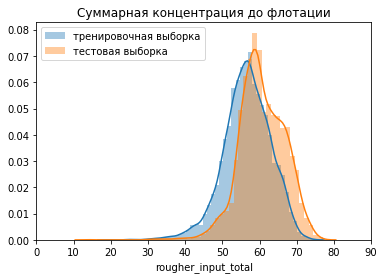

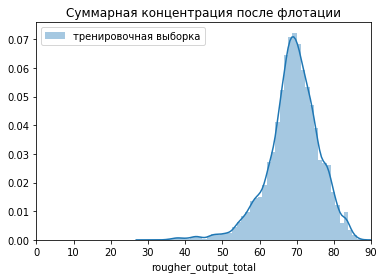

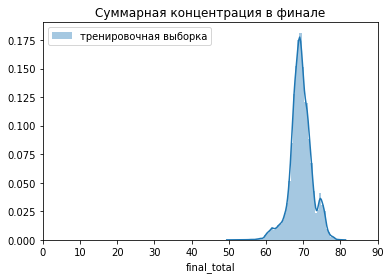

In [25]:
gold_train['rougher_input_total'] = gold_train[rougher_input_columns].sum(axis=1)
gold_test['rougher_input_total'] = gold_test[rougher_input_columns].sum(axis=1)
sns.distplot(gold_train['rougher_input_total'].reset_index(drop=True), label='тренировочная выборка')
sns.distplot(gold_test['rougher_input_total'].reset_index(drop=True), label='тестовая выборка')
plt.legend()
plt.xlim(0,90)
# plt.ylim(0,0.4)
plt.title('Суммарная концентрация до флотации')
plt.show()

gold_train['rougher_output_total'] = gold_train[rougher_output_columns].sum(axis=1)
sns.distplot(gold_train['rougher_output_total'].reset_index(drop=True), label='тренировочная выборка')
plt.legend()
plt.xlim(0,90)
plt.title('Суммарная концентрация после флотации')
plt.show()

gold_train['final_total'] = gold_train[final_columns].sum(axis=1)
sns.distplot(gold_train['final_total'].reset_index(drop=True), label='тренировочная выборка')
plt.legend()
plt.xlim(0,90)
plt.title('Суммарная концентрация в финале')
plt.show()




__Вывод__

Значение концентраций всех веществ на каждом этапе близки к нормальному распределению.

Аномалии в данных отсутсвут. Виден небольшой полупик на третьем графике. 

# 3. Модель

### 3.1. Напишите функцию для вычисления итоговой sMAPE

In [26]:
def smape(y_true, y_pred):
    return  np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100/len(y_true) 

score=make_scorer(smape, greater_is_better=False)

### 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

In [27]:
gold_train=gold_train.dropna()
gold_test=gold_test.dropna()
gold_train_features = gold_train.drop(['rougher.output.recovery', 'final.output.recovery'],axis=1)[gold_test.columns]
gold_train_target_rougher=gold_train['rougher.output.recovery']
gold_train_target_final=gold_train['final.output.recovery']

In [28]:
target_columns = ['rougher.output.recovery','final.output.recovery']
from_gold_to_test = gold[target_columns]
gold_test_with_target = pd.merge(left=gold_test, right=from_gold_to_test, left_on=gold_test.index, right_on=from_gold_to_test.index)

In [29]:
gold_test_features=gold_test_with_target.drop(['key_0','rougher.output.recovery','final.output.recovery'],axis=1)
gold_train.reset_index(drop=True)
gold_test_features.reset_index(drop=True)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher_input_total
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,72.871822
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,71.669225
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,73.202598
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,70.757057
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,68.654396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,-499.599127,...,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909,68.910849
4860,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,-503.587739,...,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761,67.166899
4861,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,-520.667442,...,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882,66.955814
4862,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,-487.479567,...,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284,67.420094


__Константная модель__

Создадим константную модель, заполнив её медианным значением, чтобы сравнивать с ней дальнейшие результаты предсказаний.

In [30]:
rougher_constant = pd.Series([gold_train['rougher.output.recovery'].median() for x in range(len(gold_test_with_target['rougher.output.recovery'].index))])
final_constant = pd.Series([gold_train['final.output.recovery'].median() for x in range(len(gold_test_with_target['final.output.recovery'].index))])

In [31]:
smape_rougher = (smape(gold_test_with_target['rougher.output.recovery'],
                       rougher_constant))
smape_final = smape(gold_test_with_target['final.output.recovery'],final_constant)
ismape = 0.25*smape_rougher+0.75*smape_final
print('Итоговое значение sMAPE для константной модели равно {:.2f}'.format(ismape))

Итоговое значение sMAPE для константной модели равно 6.72


__Обучение модели линейной регрессии__

Для каждой модели сначала проводим кросс-валидацию на тренировочных данных. После этого проводим анализ на тестовых данных, после чего сравниваем с константной моделью.

In [32]:
model_linreg_rougher = LinearRegression(normalize=True)
model_linreg_final = LinearRegression(normalize=True)

In [33]:
linreg_pred_rougher = cross_val_predict(model_linreg_rougher, gold_train_features, gold_train_target_rougher, cv=7)

linreg_pred_final = cross_val_predict(model_linreg_final, gold_train_features, gold_train_target_final, cv=7)


# scores = cross_val_score(model_linreg_rougher, gold_train_features, gold_train_target_rougher, cv=3, scoring=score)   

# print (scores, np.mean(scores), np.std(scores))

In [34]:
smape_rougher = smape(gold_train_target_rougher,linreg_pred_rougher)
smape_final = smape(gold_train_target_final,linreg_pred_final)
ismape = 0.25*smape_rougher+0.75*smape_final
print('Итоговое значение sMAPE на кросс-валидации на тренировочных данных при линейной регресии равно {:.2f}'.format(ismape))

Итоговое значение sMAPE на кросс-валидации на тренировочных данных при линейной регресии равно 8.13


In [35]:
model_linreg_rougher.fit(gold_train_features,gold_train_target_rougher)
gold_test_with_target['predicted_rougher'] = model_linreg_rougher.predict(gold_test_features)

model_linreg_final.fit(gold_train_features,gold_train_target_final)
gold_test_with_target['predicted_final'] = model_linreg_final.predict(gold_test_features)

In [36]:
smape_rougher = (smape(gold_test_with_target['rougher.output.recovery'],
                       gold_test_with_target['predicted_rougher']))
smape_final = smape(gold_test_with_target['final.output.recovery'],gold_test_with_target['predicted_final'])
ismape = 0.25*smape_rougher+0.75*smape_final
print('Итоговое значение sMAPE на тестовых данных при линейной регресии равно {:.2f}'.format(ismape))

Итоговое значение sMAPE на тестовых данных при линейной регресии равно 6.66


__Обучение модели Stochastic Gradient Descent__

In [37]:
model_sgd_rougher = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3, random_state=12345))
model_sgd_final = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3, random_state=12345))

In [38]:
sgd_pred_rougher = cross_val_predict(model_sgd_rougher, gold_train_features, gold_train_target_rougher, cv=7)

sgd_pred_final = cross_val_predict(model_sgd_final, gold_train_features, gold_train_target_final, cv=7)

In [39]:
smape_rougher = smape(gold_train_target_rougher,sgd_pred_rougher)
smape_final = smape(gold_train_target_final,sgd_pred_final)
ismape = 0.25*smape_rougher+0.75*smape_final
print('Итоговое значение sMAPE на кросс-валидации на тренировочных данных при Stochastic Gradient Descent равно {:.2f}'.format(ismape))

Итоговое значение sMAPE на кросс-валидации на тренировочных данных при Stochastic Gradient Descent равно 8.18


In [40]:
model_sgd_rougher.fit(gold_train_features,gold_train_target_rougher)
gold_test_with_target['predicted_rougher'] = model_sgd_rougher.predict(gold_test_features)

model_sgd_final.fit(gold_train_features,gold_train_target_final)
gold_test_with_target['predicted_final'] = model_sgd_final.predict(gold_test_features)

In [41]:
smape_rougher = (smape(gold_test_with_target['rougher.output.recovery'],
                       gold_test_with_target['predicted_rougher']))
smape_final = smape(gold_test_with_target['final.output.recovery'],gold_test_with_target['predicted_final'])
ismape = 0.25*smape_rougher+0.75*smape_final
print('Итоговое значение sMAPE на тестовых данных при Stochastic Gradient Descent равно {:.2f}'.format(ismape))

Итоговое значение sMAPE на тестовых данных при Stochastic Gradient Descent равно 6.76


__Обучение модели к-ближайших соседей__

In [42]:
model_knn_rougher = KNeighborsRegressor()
model_knn_final = KNeighborsRegressor()

In [43]:
knn_pred_rougher = cross_val_predict(model_knn_rougher, gold_train_features, gold_train_target_rougher, cv=7)

knn_pred_final = cross_val_predict(model_knn_final, gold_train_features, gold_train_target_final, cv=7)

In [44]:
smape_rougher = smape(gold_train_target_rougher,knn_pred_rougher)
smape_final = smape(gold_train_target_final,knn_pred_final)
ismape = 0.25*smape_rougher+0.75*smape_final
print('Итоговое значение sMAPE на кросс-валидации на тренировочных данных при модели к-ближайших соседей равно {:.2f}'.format(ismape))

Итоговое значение sMAPE на кросс-валидации на тренировочных данных при модели к-ближайших соседей равно 9.78


In [45]:
model_knn_rougher.fit(gold_train_features,gold_train_target_rougher)
gold_test_with_target['predicted_rougher'] = model_knn_rougher.predict(gold_test_features)

model_knn_final.fit(gold_train_features,gold_train_target_final)
gold_test_with_target['predicted_final'] = model_knn_final.predict(gold_test_features)

In [46]:
smape_rougher = (smape(gold_test_with_target['rougher.output.recovery'],
                       gold_test_with_target['predicted_rougher']))
smape_final = smape(gold_test_with_target['final.output.recovery'],gold_test_with_target['predicted_final'])
ismape = 0.25*smape_rougher+0.75*smape_final
print('Итоговое значение sMAPE на тестовых данных при к-ближайших соседей равно {:.2f}'.format(ismape))

Итоговое значение sMAPE на тестовых данных при к-ближайших соседей равно 8.40


__Построение модели гребневой регрессии со встроенной кросс-валидацией__

In [47]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
score=make_scorer(smape, greater_is_better=False)


In [57]:
#подбираем лучшие параметры для модели Ridge
for cv in np.arange(2, 11,2):
    GS = GridSearchCV(
        cv=cv, estimator=Ridge(),
        param_grid=[{'alpha': [10e-2, 10e-1, 10e0, 10e1, 10e2]}],
        scoring=score)
    GS.fit(gold_train_features, gold_train_target_rougher)
    print('При cv = {} и {} для модели Ridge, обученной на тренировочных данных, SMAPE после флотации равно {:.2f}:\n'.format(cv, GS.best_params_, (-1)*GS.best_score_))
    
for cv in np.arange(2, 11,2):
    GS = GridSearchCV(
        cv=cv, estimator=Ridge(),
        param_grid=[{'alpha': [10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3]}],
        scoring=score)
    GS.fit(gold_train_features, gold_train_target_final)
    print('При cv = {} и {} для модели Ridge, обученной на тренировочных данных, SMAPE после финальной очистки равно {:.2f}:\n'.format(cv, GS.best_params_, (-1)*GS.best_score_))    

При cv = 2 и {'alpha': 1000.0} для модели Ridge, обученной на тренировочных данных, SMAPE после флотации равно 10.40:

При cv = 4 и {'alpha': 1000.0} для модели Ridge, обученной на тренировочных данных, SMAPE после флотации равно 6.94:

При cv = 6 и {'alpha': 1000.0} для модели Ridge, обученной на тренировочных данных, SMAPE после флотации равно 6.04:

При cv = 8 и {'alpha': 1000.0} для модели Ridge, обученной на тренировочных данных, SMAPE после флотации равно 5.81:

При cv = 10 и {'alpha': 1000.0} для модели Ridge, обученной на тренировочных данных, SMAPE после флотации равно 5.55:

При cv = 2 и {'alpha': 1000.0} для модели Ridge, обученной на тренировочных данных, SMAPE после финальной очистки равно 9.85:

При cv = 4 и {'alpha': 10000.0} для модели Ridge, обученной на тренировочных данных, SMAPE после финальной очистки равно 8.32:

При cv = 6 и {'alpha': 10000.0} для модели Ridge, обученной на тренировочных данных, SMAPE после финальной очистки равно 8.46:

При cv = 8 и {'alpha': 10

In [58]:
print('Итоговое SMAPE при cv=10 для тренировочных данных равно {:.2f}'.format(5.55*0.25+7.95*0.75))

Итоговое SMAPE при cv=10 для тренировочных данных равно 7.35


In [ ]:
smape_rougher = smape(gold_train_target_rougher,ridge_pred_rougher)
smape_final = smape(gold_train_target_final,ridge_pred_final)
ismape = 0.25*smape_rougher+0.75*smape_final
print('Итоговое значение sMAPE на кросс-валидации на тренировочных данных при модели гребневой регрессии со встроенной кросс-валидацией равно {:.2f}'.format(ismape))

In [53]:
# alphas = [10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3]
model_ridge_rougher = RidgeCV(normalize=True,cv=10,scoring = score)
model_ridge_final =  RidgeCV(normalize=True,cv=10,scoring = score)   

model_ridge_rougher.fit(gold_train_features, gold_train_target_rougher)
model_ridge_final.fit(gold_train_features, gold_train_target_final)

gold_test_with_target['predicted_rougher'] = model_ridge_rougher.predict(gold_test_features)

gold_test_with_target['predicted_final'] = model_ridge_final.predict(gold_test_features)

In [55]:
smape_rougher = (smape(gold_test_with_target['rougher.output.recovery'],
                       gold_test_with_target['predicted_rougher']))
smape_final = smape(gold_test_with_target['final.output.recovery'],gold_test_with_target['predicted_final'])
ismape = 0.25*smape_rougher+0.75*smape_final
print('Итоговое значение sMAPE на тестовых данных при модели гребневой регрессии со встроенной кросс-валидацией равно {:.2f}'.format(ismape))

Итоговое значение sMAPE на тестовых данных при модели гребневой регрессии со встроенной кросс-валидацией равно 6.12


__Построение модели методом случайного леса__

In [69]:
model_rf_rougher = RandomForestRegressor(random_state=12345,n_estimators=10)

model_rf_final = RandomForestRegressor(random_state=12345, n_estimators=10)

In [70]:
rf_pred_rougher = cross_val_predict(model_rf_rougher, gold_train_features, gold_train_target_rougher, cv=3)

rf_pred_final = cross_val_predict(model_rf_final,gold_train_features, gold_train_target_final, cv=3)

__Примечание:__ очень долго загружался Jupyter,  поэтому уменьшил количество cv до трёх

In [71]:
smape_rougher = smape(gold_train_target_rougher,rf_pred_rougher)
smape_final = smape(gold_train_target_final,rf_pred_final)
ismape = 0.25*smape_rougher+0.75*smape_final
print('Итоговое значение sMAPE на кросс-валидации на тренировочных данных при модели случайного леса равно {:.2f}'.format(ismape))

Итоговое значение sMAPE на кросс-валидации на тренировочных данных при модели случайного леса равно 9.04


In [72]:
model_rf_rougher.fit(gold_train_features,gold_train_target_rougher)
gold_test_with_target['predicted_rougher'] = model_rf_rougher.predict(gold_test_features)

model_rf_final.fit(gold_train_features,gold_train_target_final)
gold_test_with_target['predicted_final'] = model_rf_final.predict(gold_test_features)

In [73]:
smape_rougher = (smape(gold_test_with_target['rougher.output.recovery'],
                       gold_test_with_target['predicted_rougher']))
smape_final = smape(gold_test_with_target['final.output.recovery'],gold_test_with_target['predicted_final'])
ismape = 0.25*smape_rougher+0.75*smape_final
print('Итоговое значение sMAPE на тестовых данных при модели случайного леса равно {:.2f}'.format(ismape))

Итоговое значение sMAPE на тестовых данных при модели случайного леса равно 6.62


__Итоговый вывод__

Наилучший результат, из представленных выше, при параметрах по умолчанию, выдаёт модель гребневой регрессии со встроенной кросс-валидацией.
Также она соответсвует условию - итовое MAPE ниже, чем у константной модели.

Итоговые результаты:

  <table border="1" width="100%" cellpadding="5">
   <tr>
    <th></th>
    <th>Итоговое SMAPE на тренировочных данных</th>
    <th>Итоговое SMAPE на тестовых данных</th>
   </tr>
   <tr>
    <td>Константная модель</td>   
    <td></td>
    <td bgcolor="#FFFF00">6.72</td>
  </tr>
    <tr>
    <td>Модель линейной регрессии</td>   
    <td>8.13</td>
    <td bgcolor="#32CD32">6.66</td>
  </tr>
  </tr>
    <tr>
    <td>Модель Stochastic Gradient Descent</td>   
    <td>8.18</td>
    <td>6.76</td>
  </tr>
  </tr>
    <tr>
    <td>Модель к-ближайших соседей</td>   
    <td>9.78</td>
    <td>8.40</td>
  </tr>
  </tr>
    <tr>
    <td>Модель гребневой регрессии со встроенной кросс-валидацией</td>   
    <td >7.35</td>
    <td bgcolor="#32CD32">6.12</td>
  </tr>
  </tr>
    <tr>
    <td>Модель случайного леса</td>   
    <td>9,04</td>
    <td bgcolor="#32CD32">6.62</td>
  </tr>
 </table>
 
 
 
## Итог

Только 3 модели достигли требуемого показателя (итовое MAPE ниже, чем у константной модели).

Из них модель гребневой регрессии со встроенной кросс-валидацией лидирует с заметным отрывом!